<a href="https://colab.research.google.com/github/geoskyr/ModelAgnosticMetaLearning/blob/main/MAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rarfile
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import rarfile
import os

# Provide the path to the .rar file
rar_file_path = '/content/drive/MyDrive/cub.rar'
extract_dir = '/content/extracted_files'  # Directory where you want to extract files

# Ensure the extraction directory exists
os.makedirs(extract_dir, exist_ok=True)

# Open the .rar file and extract it
with rarfile.RarFile(rar_file_path) as rf:
    rf.extractall(path=extract_dir)

# Verify the contents
!ls /content/extracted_files


images


In [4]:
import os
import shutil
import random

original_dir = '/content/extracted_files/images'  # Update with your dataset directory
train_dir = '/content/cub_train'  # Directory for training images
test_dir = '/content/cub_test'    # Directory for testing images

In [5]:
# List all the class folders
all_classes = os.listdir(original_dir)

# Select 80 random classes
selected_classes = random.sample(all_classes, 80)

# Split into 60 for training and 20 for testing
train_classes = selected_classes[:60]
test_classes = selected_classes[60:]


In [6]:
# Copy selected training classes to the train directory
for cls in train_classes:
    src_path = os.path.join(original_dir, cls)
    dest_path = os.path.join(train_dir, cls)
    shutil.copytree(src_path, dest_path)

# Copy selected testing classes to the test directory
for cls in test_classes:
    src_path = os.path.join(original_dir, cls)
    dest_path = os.path.join(test_dir, cls)
    shutil.copytree(src_path, dest_path)
    # List the contents of the train and test directories to verify the split
print("Training Classes:", os.listdir(train_dir))
print("Testing Classes:", os.listdir(test_dir))



Training Classes: ['073.Blue_Jay', '166.Golden_winged_Warbler', '108.White_necked_Raven', '170.Mourning_Warbler', '124.Le_Conte_Sparrow', '193.Bewick_Wren', '117.Clay_colored_Sparrow', '033.Yellow_billed_Cuckoo', '150.Sage_Thrasher', '120.Fox_Sparrow', '058.Pigeon_Guillemot', '181.Worm_eating_Warbler', '087.Mallard', '005.Crested_Auklet', '014.Indigo_Bunting', '164.Cerulean_Warbler', '105.Whip_poor_Will', '050.Eared_Grebe', '119.Field_Sparrow', '180.Wilson_Warbler', '001.Black_footed_Albatross', '146.Forsters_Tern', '140.Summer_Tanager', '118.House_Sparrow', '007.Parakeet_Auklet', '135.Bank_Swallow', '076.Dark_eyed_Junco', '163.Cape_May_Warbler', '011.Rusty_Blackbird', '109.American_Redstart', '137.Cliff_Swallow', '103.Sayornis', '175.Pine_Warbler', '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '132.White_crowned_Sparrow', '188.Pileated_Woodpecker', '106.Horned_Puffin', '022.Chuck_will_Widow', '171.Myrtle_Warbler', '018.Spotted_Catbird', '063.Ivory_Gull', '174.Palm_Warbler', 

In [ ]:
import os

def count_subdirectories(directory):
    subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    return len(subdirs)

# Example usage
directory = '/content/dir/train'
total_subdirectories = count_subdirectories(directory)
print(f"Total number of subdirectories in '{directory}': {total_subdirectories}")

Episode Generation

In [7]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.autograd import grad
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import copy
import tqdm
import matplotlib.pyplot as plt

def generate_episode(data_dir, num_classes, num_support_samples, num_query_samples):
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    selected_classes = random.sample(classes, num_classes)

    selected_images = {}
    for cls in selected_classes:
        images = [os.path.join(data_dir, cls, img) for img in os.listdir(os.path.join(data_dir, cls))]
        selected_images[cls] = images

    support_images, support_labels, query_images, query_labels = [], [], [], []

    for class_index, cls in enumerate(selected_classes):
        images = selected_images[cls]
        support_images_class = random.sample(images, num_support_samples)
        support_images.extend(support_images_class)
        support_labels.extend([class_index] * num_support_samples)

        remaining_images = list(set(images) - set(support_images_class))
        query_images_class = random.sample(remaining_images, num_query_samples)
        query_images.extend(query_images_class)
        query_labels.extend([class_index] * num_query_samples)
    #print('Support Labels: ',support_labels)

    return support_images, query_images, support_labels, query_labels

# Visualization function
def visualize_episode(support_images, query_images, support_labels, query_labels, num_classes, num_support_samples, num_query_samples):
    total_support = num_classes * num_support_samples
    total_query = num_classes * num_query_samples
    total_images = total_support + total_query

    fig, axes = plt.subplots(2, max(total_support, total_query), figsize=(max(total_support, total_query) * 2, 6))

    for idx, (img_path, label) in enumerate(zip(support_images, support_labels)):
        image = Image.open(img_path).convert('RGB')
        axes[0, idx].imshow(image)
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f"Support: Class {label}")

    for j in range(len(support_images), axes[0].size):
        axes[0, j].axis('off')

    for idx, (img_path, label) in enumerate(zip(query_images, query_labels)):
        image = Image.open(img_path).convert('RGB')
        axes[1, idx].imshow(image)
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f"Query: Class {label}")

    for j in range(len(query_images), axes[1].size):
        axes[1, j].axis('off')

    plt.tight_layout()
    plt.show()

Create an episode and visualize it to make sure that the images and labels are placed correctly

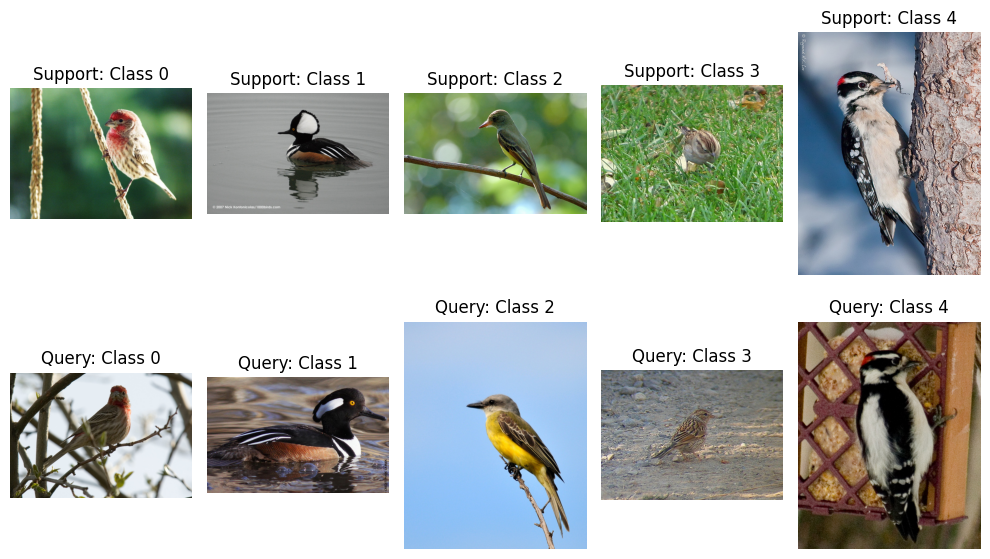

In [8]:
dir = '/content/cub_test'
num_classes = 5
num_support_samples = 1
num_query_samples = 1
num_episodes = 1

# Transform for images
transform = transforms.Compose([
    # Uncomment if resizing is necessary
    transforms.Resize((84, 84)),
    transforms.ToTensor()
])

# Generate test episodes with progress bar
si,qi,sl,ql = generate_episode(dir, num_classes, num_support_samples, num_query_samples)
visualize_episode(si, qi, sl, ql, num_classes, num_support_samples, num_query_samples)

Model Creation and defintion of the inner and outer loops that will be used during training . In the inner loop the weight updates are temporary so we need to create a copy of the model and apply the changes there . The model that is used as a classifier is ResNet-34

In [14]:

import torch.optim.lr_scheduler as lr_scheduler
# Define the ResNet model with a new head
class ResNetWithNewHead(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNetWithNewHead, self).__init__()
        self.backbone = models.resnet34(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

def inner_loop(model, support_images, support_labels, inner_lr , num_of_updates):
    # Make a copy of the model for temporary changes
    model_copy = copy.deepcopy(model)

    # Set the optimizer for the inner loop
    inner_optimizer = torch.optim.Adam(model_copy.parameters(), lr=inner_lr)

    # Prepare the support images and labels
    support_images_tensors = [transform(Image.open(img_path).convert('RGB')).to(device) for img_path in support_images]
    support_images_tensors = torch.stack(support_images_tensors)  # Convert list of tensors to a single tensor
    support_labels_tensor = torch.tensor(support_labels).long().to(device)
    for x in range(num_of_updates):
    # Forward pass
     outputs = model_copy(support_images_tensors)

    # Compute the loss
     loss_fn = nn.CrossEntropyLoss()
     loss = loss_fn(outputs, support_labels_tensor)

    # Backward pass and optimization
     inner_optimizer.zero_grad()
     loss.backward()
     inner_optimizer.step()

    return model_copy

def outer_loop(model, episodes, outer_lr, batch_size):
    # Set the optimizer for the outer loop
    outer_optimizer = torch.optim.Adam(model.parameters(), lr=outer_lr)
    scheduler = lr_scheduler.StepLR(outer_optimizer, step_size=100, gamma=0.5)

    # Initialize loss function
    loss_fn = nn.CrossEntropyLoss()

    # Iterate over episodes in batches
    for batch_start in tqdm(range(0, len(episodes), batch_size), desc="Processing Batches"):
        total_outer_loss = 0  # Initialize total loss for the batch

        # Process each episode in the batch
        for episode in episodes[batch_start:batch_start+batch_size]:
            support_images, query_images, support_labels, query_labels = episode

            # Perform the inner loop
            model_copy = inner_loop(model, support_images, support_labels, inner_lr=5e-4, num_of_updates=3)

            # Prepare the query images and labels
            query_images_tensors = [transform(Image.open(img_path).convert('RGB')).to(device) for img_path in query_images]
            query_images_tensors = torch.stack(query_images_tensors)
            query_labels_tensor = torch.tensor(query_labels).long().to(device)

            # Forward pass with the adapted model
            query_outputs = model_copy(query_images_tensors)

            # Compute the loss for the outer loop
            outer_loss = loss_fn(query_outputs, query_labels_tensor)

            # Accumulate the loss
            total_outer_loss += outer_loss

        # After processing the batch, backpropagate and update the model
        outer_optimizer.zero_grad()
        batch_loss=total_outer_loss/batch_size
        batch_loss.backward()  # Backpropagate accumulated loss
        outer_optimizer.step()  # Update model parameters

        # Print the loss for monitoring
        if(batch_start % 50 == 0):

         print(f"Batch {batch_start // batch_size + 1}/{len(episodes) // batch_size + 1}, Loss: {round(batch_loss.item(), 5)}")
        #scheduler.step()

        # Print the current learning rate
        #current_lr = outer_optimizer.param_groups[0]['lr']
        #print(f"Current learning rate: {current_lr}")

# Example usage
data_dir = '/content/cub_train'
num_classes = 5
num_support_samples = 5
num_query_samples = 5
num_episodes = 2500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((84, 84)),  # Resize the image to the required input size for ResNet
    transforms.ToTensor(),            # Convert the image to a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Instantiate the model
model = ResNetWithNewHead(num_classes=num_classes).to(device)




Train Model

In [15]:
from tqdm import tqdm
# Generate episodes (this function needs to be defined by you)
episodes = [generate_episode(data_dir, num_classes, num_support_samples, num_query_samples) for _ in range(num_episodes)]

# Train the model using the outer loop
outer_loop(model, episodes, outer_lr=5e-5, batch_size=10)

Processing Batches:   0%|          | 1/250 [00:03<15:52,  3.82s/it]

Batch 1/251, Loss: 1.20467


Processing Batches:   2%|▏         | 6/250 [00:20<13:40,  3.36s/it]

Batch 6/251, Loss: 1.05931


Processing Batches:   4%|▍         | 11/250 [00:37<13:16,  3.33s/it]

Batch 11/251, Loss: 1.31775


Processing Batches:   6%|▋         | 16/250 [00:54<13:30,  3.46s/it]

Batch 16/251, Loss: 1.03659


Processing Batches:   8%|▊         | 21/250 [01:11<13:03,  3.42s/it]

Batch 21/251, Loss: 1.26798


Processing Batches:  10%|█         | 26/250 [01:28<12:38,  3.39s/it]

Batch 26/251, Loss: 1.14306


Processing Batches:  12%|█▏        | 31/250 [01:45<12:50,  3.52s/it]

Batch 31/251, Loss: 1.20362


Processing Batches:  14%|█▍        | 36/250 [02:02<12:17,  3.44s/it]

Batch 36/251, Loss: 1.23461


Processing Batches:  16%|█▋        | 41/250 [02:19<11:36,  3.33s/it]

Batch 41/251, Loss: 1.06699


Processing Batches:  18%|█▊        | 46/250 [02:36<11:26,  3.37s/it]

Batch 46/251, Loss: 0.9796


Processing Batches:  20%|██        | 51/250 [02:53<11:30,  3.47s/it]

Batch 51/251, Loss: 1.06177


Processing Batches:  22%|██▏       | 56/250 [03:10<10:55,  3.38s/it]

Batch 56/251, Loss: 1.31212


Processing Batches:  24%|██▍       | 61/250 [03:27<10:27,  3.32s/it]

Batch 61/251, Loss: 1.06113


Processing Batches:  26%|██▋       | 66/250 [03:44<10:41,  3.49s/it]

Batch 66/251, Loss: 1.16823


Processing Batches:  28%|██▊       | 71/250 [04:01<10:08,  3.40s/it]

Batch 71/251, Loss: 1.15305


Processing Batches:  30%|███       | 76/250 [04:17<09:34,  3.30s/it]

Batch 76/251, Loss: 1.15924


Processing Batches:  32%|███▏      | 81/250 [04:35<09:41,  3.44s/it]

Batch 81/251, Loss: 1.24788


Processing Batches:  34%|███▍      | 86/250 [04:52<09:27,  3.46s/it]

Batch 86/251, Loss: 1.17725


Processing Batches:  36%|███▋      | 91/250 [05:08<08:56,  3.37s/it]

Batch 91/251, Loss: 1.3072


Processing Batches:  38%|███▊      | 96/250 [05:26<08:49,  3.44s/it]

Batch 96/251, Loss: 1.05915


Processing Batches:  40%|████      | 101/250 [05:43<08:34,  3.46s/it]

Batch 101/251, Loss: 1.01145


Processing Batches:  42%|████▏     | 106/250 [06:00<08:02,  3.35s/it]

Batch 106/251, Loss: 1.12881


Processing Batches:  44%|████▍     | 111/250 [06:17<07:44,  3.34s/it]

Batch 111/251, Loss: 1.1005


Processing Batches:  46%|████▋     | 116/250 [06:34<07:52,  3.52s/it]

Batch 116/251, Loss: 1.13658


Processing Batches:  48%|████▊     | 121/250 [06:51<07:22,  3.43s/it]

Batch 121/251, Loss: 1.31567


Processing Batches:  50%|█████     | 126/250 [07:08<07:02,  3.41s/it]

Batch 126/251, Loss: 1.16418


Processing Batches:  52%|█████▏    | 131/250 [07:26<06:57,  3.51s/it]

Batch 131/251, Loss: 0.95881


Processing Batches:  54%|█████▍    | 136/250 [07:43<06:32,  3.45s/it]

Batch 136/251, Loss: 0.99397


Processing Batches:  56%|█████▋    | 141/250 [08:00<06:13,  3.43s/it]

Batch 141/251, Loss: 1.18502


Processing Batches:  58%|█████▊    | 146/250 [08:17<06:00,  3.46s/it]

Batch 146/251, Loss: 1.12123


Processing Batches:  60%|██████    | 151/250 [08:34<05:45,  3.49s/it]

Batch 151/251, Loss: 1.21985


Processing Batches:  62%|██████▏   | 156/250 [08:51<05:16,  3.37s/it]

Batch 156/251, Loss: 1.09501


Processing Batches:  64%|██████▍   | 161/250 [09:08<05:02,  3.39s/it]

Batch 161/251, Loss: 1.01043


Processing Batches:  66%|██████▋   | 166/250 [09:25<04:48,  3.44s/it]

Batch 166/251, Loss: 1.01037


Processing Batches:  68%|██████▊   | 171/250 [09:42<04:26,  3.37s/it]

Batch 171/251, Loss: 1.10368


Processing Batches:  70%|███████   | 176/250 [09:59<04:06,  3.34s/it]

Batch 176/251, Loss: 1.13262


Processing Batches:  72%|███████▏  | 181/250 [10:16<04:00,  3.49s/it]

Batch 181/251, Loss: 1.18046


Processing Batches:  74%|███████▍  | 186/250 [10:33<03:37,  3.40s/it]

Batch 186/251, Loss: 1.34543


Processing Batches:  76%|███████▋  | 191/250 [10:50<03:20,  3.39s/it]

Batch 191/251, Loss: 1.17826


Processing Batches:  78%|███████▊  | 196/250 [11:07<03:07,  3.47s/it]

Batch 196/251, Loss: 1.17521


Processing Batches:  80%|████████  | 201/250 [11:24<02:47,  3.42s/it]

Batch 201/251, Loss: 0.97427


Processing Batches:  82%|████████▏ | 206/250 [11:41<02:27,  3.35s/it]

Batch 206/251, Loss: 1.2727


Processing Batches:  84%|████████▍ | 211/250 [11:58<02:13,  3.41s/it]

Batch 211/251, Loss: 1.05796


Processing Batches:  86%|████████▋ | 216/250 [12:15<01:59,  3.51s/it]

Batch 216/251, Loss: 1.1432


Processing Batches:  88%|████████▊ | 221/250 [12:32<01:38,  3.38s/it]

Batch 221/251, Loss: 1.2573


Processing Batches:  90%|█████████ | 226/250 [12:49<01:20,  3.35s/it]

Batch 226/251, Loss: 1.06284


Processing Batches:  92%|█████████▏| 231/250 [13:06<01:06,  3.49s/it]

Batch 231/251, Loss: 1.34497


Processing Batches:  94%|█████████▍| 236/250 [13:23<00:47,  3.41s/it]

Batch 236/251, Loss: 1.21882


Processing Batches:  96%|█████████▋| 241/250 [13:40<00:30,  3.37s/it]

Batch 241/251, Loss: 1.10717


Processing Batches:  98%|█████████▊| 246/250 [13:57<00:13,  3.50s/it]

Batch 246/251, Loss: 1.21904


Processing Batches: 100%|██████████| 250/250 [14:11<00:00,  3.41s/it]


In [ ]:
import gc
#del model  # Delete the model
del episodes
#del test_episodes  # Delete the episodes list, if it's very large
gc.collect()  # Force garbage collection
torch.cuda.empty_cache()  # Empty PyTorch's CUDA cache

NameError: name 'episodes' is not defined

Eval

In [12]:
def inner_loop_eval(model, support_images, support_labels, inner_lr , num_of_updates):
    # Make a copy of the model for temporary changes
    model_copy = copy.deepcopy(model)
    #print('Inner Loop Labels: ',support_labels)

    # Set the optimizer for the inner loop
    inner_optimizer = torch.optim.Adam(model_copy.parameters(), lr=inner_lr)

    # Prepare the support images and labels
    support_images_tensors = [transform(Image.open(img_path).convert('RGB')).to(device) for img_path in support_images]
    support_images_tensors = torch.stack(support_images_tensors)  # Convert list of tensors to a single tensor
    support_labels_tensor = torch.tensor(support_labels).long().to(device)

    for i in range(num_of_updates):
     #print(i)

    # Forward pass
     outputs = model_copy(support_images_tensors)

    # Compute the loss
     loss_fn = nn.CrossEntropyLoss()
     loss = loss_fn(outputs, support_labels_tensor)
     #print('loss: ',loss)

    # Backward pass and optimization (weight updates) #
     inner_optimizer.zero_grad()
     loss.backward()
     inner_optimizer.step()

    return model_copy


def outer_loop_eval(model, episodes):
    # Set the optimizer for the outer loop

    i=0
    # Initialize loss function
    loss_fn = nn.CrossEntropyLoss()
    accs=[]
    total_correct=0
    total_queries=0

    for episode in episodes:
        i+=1
        support_images, query_images, support_labels, query_labels = episode
       # print('Outer Loop Labels: ',support_labels)
       # print('Query Labels: ',query_labels)

        # Perform the inner loop
        model_copy = inner_loop_eval(model, support_images, support_labels, inner_lr=5e-4 ,num_of_updates=3)

        # Prepare the query images and labels
        query_images_tensors = [transform(Image.open(img_path).convert('RGB')).to(device) for img_path in query_images]
        query_images_tensors = torch.stack(query_images_tensors)
        query_labels_tensor = torch.tensor(query_labels).long().to(device)
        #print('query labels: ',query_labels_tensor)

        # Forward pass with the adapted model
        query_outputs = model_copy(query_images_tensors)
        #print('Outputs: ',query_outputs)

        _, predicted_classes = torch.max(query_outputs, dim=1) ## Find index with biggest probability ##
        #print('preds: ',predicted_classes)
        # Calculate the number of correct predictions
        total_correct += (predicted_classes == query_labels_tensor).sum().item()
        total_queries += query_labels_tensor.size(0)
        episode_accuracy = total_correct / total_queries if total_queries > 0 else 0.0
        accs.append(episode_accuracy)
    mean_accuracy = np.mean(accs) if accs else 0.0
    print(f"Total Correct: {total_correct}, Total Queries: {total_queries}, Accuracy: {episode_accuracy:.4f}")


In [16]:
from tqdm import tqdm
import torch
from torchvision import transforms

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Parameters
dir = '/content/cub_test'
num_classes = 5
num_support_samples = 5
num_query_samples = 5
num_episodes = 300

# Transform for images
transform = transforms.Compose([
    # Uncomment if resizing is necessary
    transforms.Resize((84, 84)),
    transforms.ToTensor()
])

# Generate test episodes with progress bar
test_episodes = [generate_episode(dir, num_classes, num_support_samples, num_query_samples)
                 for _ in tqdm(range(num_episodes), desc="Generating Episodes")]


outer_loop_eval(model, test_episodes)

Device: cuda


Generating Episodes: 100%|██████████| 300/300 [00:00<00:00, 1574.96it/s]


Total Correct: 4750, Total Queries: 7500, Accuracy: 0.6333


Episode Generator